In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math
from sklearn.metrics import mean_squared_error

In [2]:
data_ref = pd.read_excel("Rw_ref_curves.xlsx", sheet_name="Ref")
PW_parametric = pd.read_csv("PW_parstud_combined_4phyt.csv")

In [3]:
list_freq = [
    '100','125','160',
    '200','250','315',
    '400','500','630',
    '800','1000','1250',
    '1600','2000',
    '2500','3150'
]

In [4]:
l = PW_parametric['l']
h = PW_parametric['h']
w = PW_parametric['w']
g = PW_parametric['g']
OL = PW_parametric['ol']
Abs_mat = PW_parametric['Abs_mat']
Measured_Rw = PW_parametric['Measured_Rw']
DoubleGlassRw = PW_parametric['DoubleGlassRw']

d = OL + w
PW_parametric['d'] = d

PW_parametric['SingleGlassRw'] = 25
SingleGlassRw = PW_parametric['SingleGlassRw']

In [5]:
sigSA_column_name = []
sigSA_per_column_name = []
Reverberation_Loss_Yabs_column_name = []
R_plenum_Yabs_column_name = []
R_plenum_Li_1_column_name = []

for data in list_freq:
    sigSA_column_name.append("sigSA_Yabs_"+data)
    sigSA_per_column_name.append("sigSA_per_sigS_Yabs_"+data)
    Reverberation_Loss_Yabs_column_name.append("Reverberation_Loss_Yabs_"+data)
    R_plenum_Yabs_column_name.append("R_plenum_Yabs_"+data)
    R_plenum_Li_1_column_name.append("R_plenum_Li_1_"+data)

In [7]:
def sigSA_Calculation(l=1, h=1, w=1, g=1):
    # calculation proses
    for index, data in enumerate(list_freq):
        PW_parametric[sigSA_column_name[index]] = ((2*l/1000*h/1000 - 2*w*h/1000000)*0.03) + ((2*g/1000*l/1000+2*g/1000*h/1000)*PW_parametric['abs_'+data]) + (2*w*h/1000000*0.9)
        PW_parametric['sigSA_Nabs'] = ((2*l/1000*h/1000 - 2*w*h/1000000)*0.03) + ((2*g/1000*l/1000+2*g/1000*h/1000)*0.05) + (2*w*h/1000000*0.9)

    for index, data in enumerate(list_freq):
        PW_parametric[sigSA_per_column_name[index]] = PW_parametric[sigSA_column_name[index]]/((2*l/1000*h/1000 - 2*w*h/1000000)+(2*g/1000*l/1000+2*g/1000*h/1000)+(2*w*h/1000000))
        PW_parametric['sigSA_per_sigS_Nabs'] = PW_parametric['sigSA_Nabs']/((2*l/1000*h/1000 - 2*w*h/1000000)+(2*g/1000*l/1000+2*g/1000*h/1000)+(2*w*h/1000000))
    
    return PW_parametric

In [8]:
def plenumLi_calculation(Q1, K1, l=1, h=1, w=1, g=1):
    PW_parametric['Diffration_Loss'] = -10*np.log10(w*h/1000000*((Q1*g/1000/(d/1000)/(4*math.pi*(d/1000)**2))))

    for index, data in enumerate(list_freq):
        PW_parametric[Reverberation_Loss_Yabs_column_name[index]] = -10*np.log10(w*h/1000000*K1*(1-PW_parametric[sigSA_per_column_name[index]])/PW_parametric[sigSA_column_name[index]])
        PW_parametric[R_plenum_Yabs_column_name[index]] = -10*np.log10(10**(PW_parametric['Diffration_Loss']/-10)+10**(PW_parametric[Reverberation_Loss_Yabs_column_name[index]]/-10))

    PW_parametric['R_plenum_Nabs'] = -10*np.log10(w*h/1000000*((Q1*g/1000/(d/1000)/(4*math.pi*(d/1000)**2)+K1*(1-PW_parametric['sigSA_per_sigS_Nabs'])/PW_parametric['sigSA_Nabs'])))

    for index, data in enumerate(list_freq):
        PW_parametric[R_plenum_Li_1_column_name[index]] = np.where(Abs_mat == "Yes", PW_parametric[R_plenum_Yabs_column_name[index]], PW_parametric['R_plenum_Nabs'])
    
    R_geometric_Yu_2 = 20* np.log10(l/w)
    PW_parametric['R_geometric_Yu_2'] = R_geometric_Yu_2
    
    return PW_parametric

In [22]:
def find_rw(data_ref, data_test):
    nama_columns_raw = list(data_ref.columns)
    nama_columns_loop = nama_columns_raw[1:]

    result = []
    for index, row in data_test.iterrows():
        num_row_loop = len(data_ref)
        check_loop = False
        for num_row in range(len(data_ref)):
            num_row_loop -=1
            sum_dev = 0
            if not check_loop:
                for col in nama_columns_loop:
                    if row[col] > data_ref[col][num_row_loop]:
                        if col == 3150:
                            if sum_dev < 32:
                                check_loop = True
                                result.append([num_row_loop,  data_ref['Rw'][num_row_loop]])
                                # print("done index: ", index)
                        else:
                            continue
                    else:
                        sum_dev += abs(row[col] - data_ref[col][num_row_loop])
                        if sum_dev > 32:
                            break
                        if col == 3150:
                            if sum_dev < 32:
                                check_loop = True
                                result.append([num_row_loop,  data_ref['Rw'][num_row_loop]])
                                # print("done index: ", index)
                        else:
                            continue
            else:
                break
    
    data_test['Rw'] = pd.DataFrame(result)[1]

    return data_test

In [20]:
def calculate_rmse(Q1, K1, optimized = False):
    PW_parametric = sigSA_Calculation()
    PW_parametric = plenumLi_calculation(Q1, K1)

    data = PW_parametric[PW_parametric.columns[-17:-1]].copy()
    data['Rw'] = 0
    col_name = list(data_ref.columns[1:].values)
    col_name.append('Rw')
    data.columns = col_name

    result = find_rw(data_ref, data)
    if optimized:
        PW_parametric['rw_optimized'] = result['Rw']
        y_true = PW_parametric['Measured_Rw']
        y_pred = result['Rw']
        print("OPTIMIZED RMSE", mean_squared_error(y_true, y_pred, squared=False))

    y_true = PW_parametric['Measured_Rw']
    y_pred = result['Rw']
    if not optimized:
        return mean_squared_error(y_true, y_pred, squared=False)
    if optimized:
        PW_parametric = sigSA_Calculation()
        PW_parametric = plenumLi_calculation(Q1_start, K1_start)
        data = PW_parametric[PW_parametric.columns[-17:-1]].copy()
        data['Rw'] = 0
        col_name = list(data_ref.columns[1:].values)
        col_name.append('Rw')
        data.columns = col_name
        result = find_rw(data_ref, data)
        y_true = PW_parametric['Measured_Rw']
        y_pred = result['Rw']
        print("ORIGINAL RMSE", mean_squared_error(y_true, y_pred, squared=False))

        PW_parametric['rw_ori'] = result['Rw']
        return PW_parametric

In [23]:
# finding best parameter

Q1_start = 1.2088
K1_start = 0.2288
# Q1_test = np.linspace(0, Q1_start, num=10)
# K1_test = np.linspace(0, K1_start, num=10)
Q1_test = np.arange(0.0001, Q1_start, step=0.1)
K1_test = np.arange(0.0001, K1_start, step=0.01)

result = [1000000,0,0]
z = []
z_ver = []

for q in Q1_test:
    temp = []
    temp_ver = []
    for k in K1_test:
        temp_result = calculate_rmse(q,k)
        temp.append(temp_result)
        temp_ver.append(q)
        temp_ver.append(k)
        temp_ver.append(temp_result)
        if temp_result < result[0]:
            result[0] = temp_result
            result[1] = q
            result[2] = k
    z.append(temp)
    z_ver.append(temp_ver)

data_result = calculate_rmse(result[1], result[2], optimized=True)

OPTIMIZED RMSE 4.517106963438982
ORIGINAL RMSE 6.969538584806485


C:\Users\Hariz\AppData\Local\Temp\ipykernel_16376\1108535597.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Rw'] = 0
C:\Users\Hariz\AppData\Local\Temp\ipykernel_16376\777386624.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Rw'] = pd.DataFrame(result)[1]


In [11]:
# data_result.to_excel('test.xlsx')

Text(0.5, 1.0, 'Simplest default with labels')

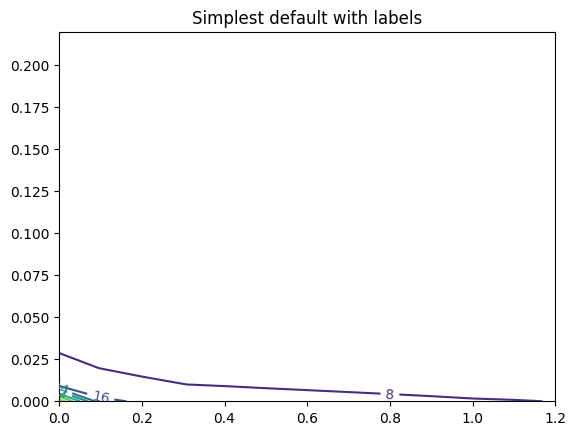

In [19]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

X, Y = np.meshgrid(Q1_test, K1_test)
Z = np.asarray(z).T

fig, ax = plt.subplots()
# plt.xlim([0.7, 1.2])
# plt.ylim([0, .04])
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Simplest default with labels')